In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score           

## R-Squared 계산 함수 정의
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))
    
## 교차 검증을 수행하는 함수 정의
def cross_validation(model, X, y, n=5): 
    cv = KFold(n, shuffle=False)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 입력 변수 가중치
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)
    
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)


In [2]:
data = pd.read_excel('CAPE.xlsx')

data.columns = ['No', 'Month', 'Line', 'Type', 'Owned',
                'BDI','IND-12', 'IND-11', 'IND-10', 'IND-9', 'IND-8', 'IND-7', 'IND-6', 'IND-5', 'IND-4', 'IND-3', 'IND-2', 'IND-1',  
                'M-12', 'M-11', 'M-10', 'M-9', 'M-8', 'M-7', 'M-6', 'M-5', 'M-4', 'M-3', 'M-2', 'M-1', 
                'M-AVG3', 'M-AVG6', 'M-AVG12',
                'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 'TC-3', 'TC-2', 'TC-1', 
                'TC-AVG3','TC-AVG6','TC-AVG12',
                'DAY_CB', 'DAY_HIRE']

data.set_index('Month', inplace=True)

data = data.drop(columns=['No', 'Line', 'Type'], axis=1)

data_owned = data[data.Owned == 'OWNED'].drop(columns=['Owned', 'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 
                                                       'TC-3', 'TC-2', 'TC-1', 'TC-AVG3','TC-AVG6','TC-AVG12', 'DAY_HIRE'], axis=1)
data_tc    = data[data.Owned == 'TC'].drop(columns=['Owned'], axis=1)


In [3]:
df_owned = data_owned.copy()
df_tc    = data_tc.copy()

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features(features, target, n_train, model):
    
    X = df_owned.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_owned.index.min(), end=df_owned.index.max(), freq='M')
    #print(xticks)

    # 년도와 월을 추출하여 xticks_name을 생성합니다.
    xticks_name = [date.strftime("%Y-%m") for date in xticks]
    #month = ["Jan", "Feb", "Mar","Apr", "May", "Jun", "Jul", "Aug", 'Oct', 'Sep', 'Nov', 'Dec']
    #xticks_name = [month[int(m)]+d for m, d in zip(xticks.strftime("%m"),xticks.strftime(" %m-%d"))]
    #plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    #print(xticks_name)
    
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    #X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=n_train, shuffle=False)
    
    model.fit(X_train, y_train)
    ##print('Train : {:.2f}'.format(model.score(X_train, y_train)))
    ##print('Test : {:.2f}'.format(model.score(X_test, y_test)))
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    #plt.xticks(range(0, len(xticks_name), 8), xticks_name, rotation=90, ha="left")
    
    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
    plt.plot(range(n_train), y_pred_train, '--', label="Train Pred")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Test Pred")
    
    plt.legend(loc='best')
    plt.title(model)
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")
    
    return y_train, y_test, y_pred

#
# 1. 사선

In [5]:


X_owned = df_owned.drop('DAY_CB', axis=1)
y_owned = df_owned.DAY_CB

n_train = int(len(X_owned)*0.75)

### 사용 모델 :  LinearRegressor, LGBMRegressor, RandomForest, SVM
### 1-1) LinearRegressor
> Max Error:  2398.894 <br>
Mean Absolute Error:  822.369 <br>
Root Mean Squared Error:  1086.122 <br>
R-Squared:  0.843
### 1-2) LGBMRegressor
> Max Error:  3612.571 <br>
Mean Absolute Error:  1432.398 <br>
Root Mean Squared Error:  1753.225 <br>
R-Squared:  0.584
### 1-3) LGBMRegressor
> Max Error:  3414.3 <br>
Mean Absolute Error:  1075.731 <br>
Root Mean Squared Error:  1415.468 <br>
R-Squared:  0.564
### 1-4) SVM
> Max Error:  3868.724 <br>
Mean Absolute Error:  1422.562 <br>
Root Mean Squared Error:  1804.189 <br>
R-Squared:  0.249

## * 사선 : LinearRegression 선택

Train Score :  0.9385567997193994 ,  Test Score :  0.8432201087450408


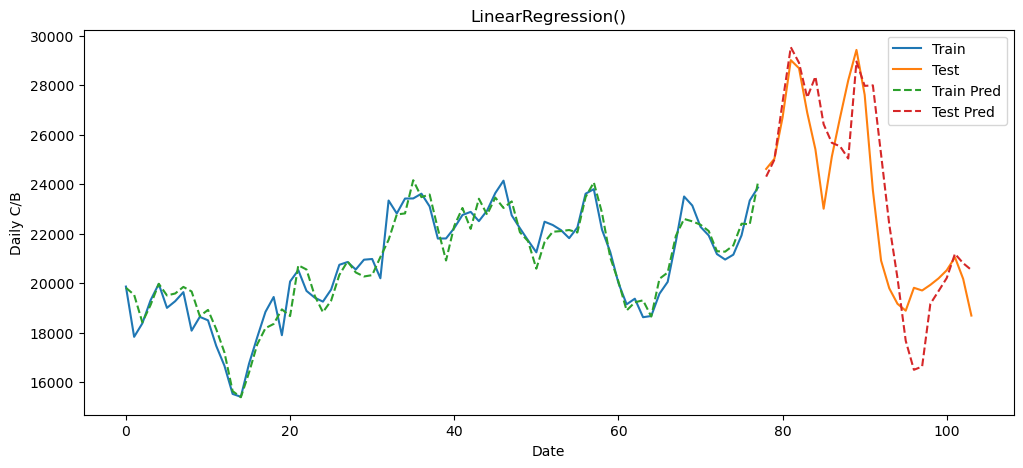

In [6]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Train Score : ', lr.score(X_train, y_train),', ','Test Score : ', lr.score(X_test, y_test))

In [7]:
show_reg_result(y_test,y_pred)

Max Error:  2398.894
Mean Absolute Error:  822.369
Root Mean Squared Error:  1086.122
R-Squared:  0.843


# 2. 용선 (PolynorminalFeatures 적용)

### 사용 모델 :  LinearRegressor,  RandomForest, SVM
### 1-1) LinearRegressor
> Max Error:  6810.958 <br>
Mean Absolute Error:  2042.3 <br>
Root Mean Squared Error:  2635.509 <br>
R-Squared:  0.077
### 1-2) RandomForest
> Max Error:  5674.9 <br>
Mean Absolute Error:  1437.622 <br>
Root Mean Squared Error:  2149.734 <br>
R-Squared:  0.918
### 1-3) SVM
>Max Error:  2441.37 <br>
Mean Absolute Error:  573.952 <br>
Root Mean Squared Error:  776.325 <br>
R-Squared:  0.98

## * PolynormalFeatures 적용
### (X_tc Feature 수 44개 -> 1034개로 990개 증가)

In [13]:
df_tc = data_tc.copy()
X_tc   = df_tc.drop('DAY_CB', axis=1)
y_hire = df_tc.DAY_HIRE
y_tc   = df_tc.DAY_CB

n_train = int(len(X_tc)*0.75)

X_tc.shape, y_hire.shape, y_tc.shape

((92, 44), (92,), (92,))

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_tc_poly    = poly.fit_transform(X_tc)
X_tc_poly.shape

(92, 1034)

## * 용선 : LinearSVR 선택

(0.9964862630859536, 0.9813208417721054)

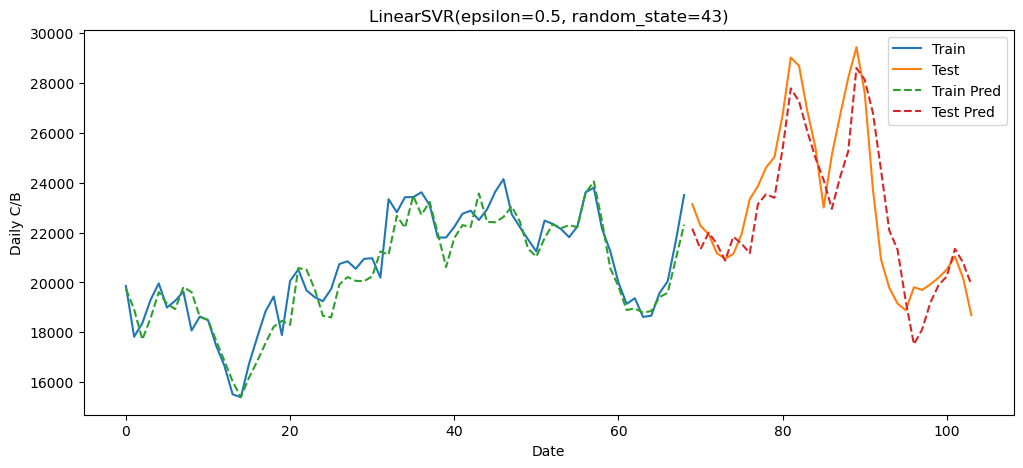

In [18]:
from sklearn.svm import LinearSVR

svm = LinearSVR(epsilon=0.5, random_state=43)
y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, svm)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

In [19]:
show_reg_result(y_test,y_pred)

Max Error:  2441.37
Mean Absolute Error:  573.952
Root Mean Squared Error:  776.325
R-Squared:  0.981


# 3. Hyper Parameter 최적화 (GridSearchCV)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris


X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=61)

para_grid = {'epsilon' : [0.5, 1.0, 1.5]}

grid_search = GridSearchCV(LinearSVR(), para_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

0.9708084382543943

In [21]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'epsilon': 0.5}, 0.9851278158253184, LinearSVR(epsilon=0.5))

### * 위 결과로 용선 - LinearSVR 매개변수(epsilon=0.5) 선택

# 4. K-Fold 교차 검증 (모델의 일반화 성능 평가)

### - 사선

In [22]:
from sklearn.model_selection import KFold, cross_val_score

lr = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(lr, X_owned, y_owned, cv=kfold)
print(score, ', Average : ', score.mean())

[0.72068788 0.92178383 0.84757491 0.76586382 0.86676697] , Average :  0.8245354820717627


### - 용선

In [23]:
from sklearn.model_selection import KFold, cross_val_score

svm = LinearSVR(epsilon=0.5, random_state=43)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(svm, X_tc, y_tc, cv=kfold)
print(score, ', Average : ', score.mean())

[0.99217894 0.98463042 0.90944776 0.97566739 0.97147478] , Average :  0.9666798587910052
